# Распространение тепла

### Условие задачи

**Дано:**
- пластина, в которой распространяется тепло от нескольких источников
  
- коэффициенты диффузии:
    -  основного материала (синий цвет) $D_0 = 1.0$
    -  включений (белый цвет) $D_1 = 10^{-2}$

- размер массива поля температур $NxN$, где $N \in [60, 120, 240, 480, 960]$

- $T_0 = 0$ - начальная температура во всем объеме пластины

- граничные условия на ребрах пластины двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = 0$
    - абсолютная теплоизоляция на ребрах
        - $x = 60$
        - $y = 60$

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$
    - источник 0: $p_0 = 100$, $\theta_0 = 43$
    - источник 1: $p_1 = 100$, $\theta_1 = 77$
    
- на пластине расположены 4 пробы (черные точки)
    
- $t_m = 600$ c - общее время моделирования

**Пример схемы пластины для варианта 0**

<img src="var_00.png" width=600/>


**Требуется:**
- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ для каждого $N$
- шаг по времени $dt$ подобрать самостоятельно так, чтобы расчетная схема сходилась
- для каждого $N$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**
    
    3. построить изображение матрицы коэффициентов диффузии

    4. построить цветовую карту поля температур в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу `colorbar`,
        - отобразить пробы в виде точек и подписать их номера.

    5. на одном рисунке построить графики температур в местах установки всех четырех проб
        - подписать оси,
        - вывести легенду.

    6. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`

    7. задокументировать все функции


**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)


**Правила оценивания:**

- оценка за корректно выполненный расчет для $N$, баллов из 100:
```
    N    =   60,  120, 240, 480, 960
    g(N) =    5,    5,  10,  30,  50
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не выполнено сохранение результатов в файл(ы) - 20
    - построение графиков не использует сохраненные результаты - 20
    - не построены графики температур в местах установки проб - 20
    - не построена карта поля температур - 20
    - не построена карта коэффициентов диффузии - 10
    - не посчитаны периоды колебаний - 20
    - отсутствует документация функций - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{k=1}^{4}{g(N_k)} - \sum_{i}{p(i)}$


In [43]:
from IPython.display import Image

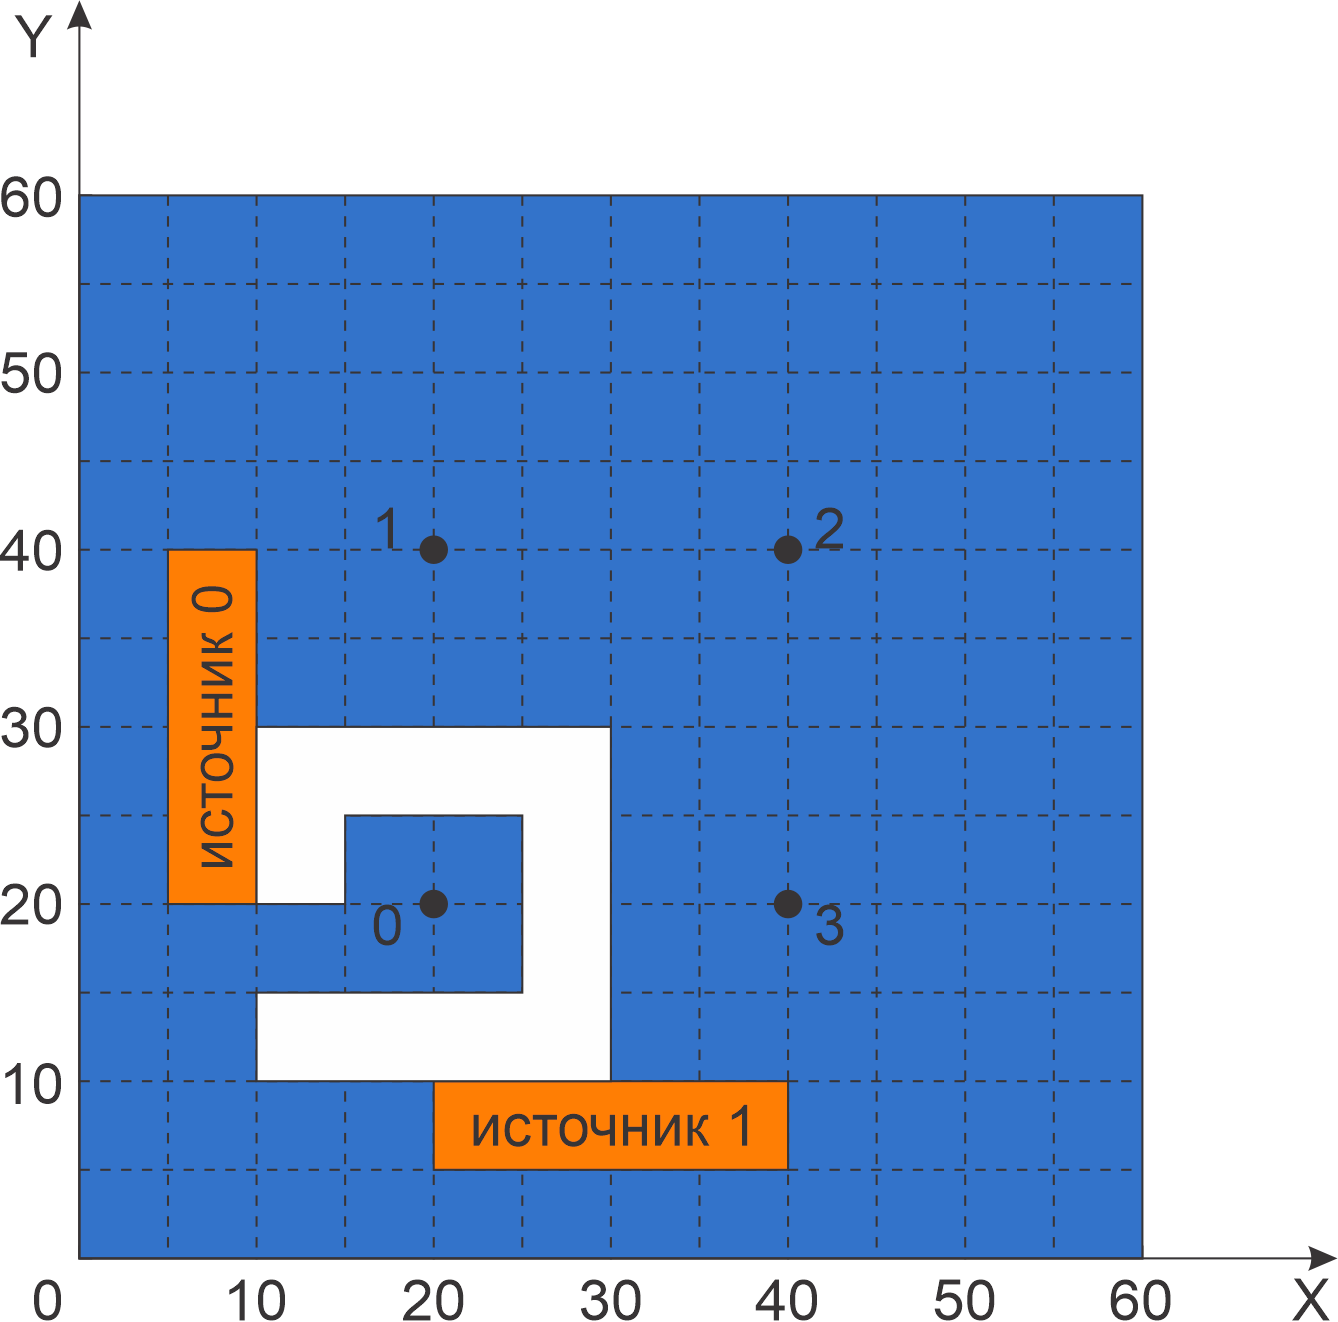

In [44]:
display(Image(filename="./task.png"))

# Решение

In [45]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from tqdm import trange
from scipy import signal

In [47]:
@nb.njit
def create_D_matrix(L: int,
                    N: int,
                    D_blue: float,
                    D_white: float) -> np.ndarray:
    """
    Заполняем матрицу с коэффициентами диффузии

    Parameters
    ----------
    L : длина пластины на чертеже
    N : реальная длина пластины
    D_blue : коэффициент диффузии синего материала
    D_white : коэффициент диффузии белого материала

    Returns
    -------
    Матрица коэффициентов диффузии
    """
    # заполняем матрицу по чертежу
    D_from_blueprint = np.full((L, L), D_blue)
    D_from_blueprint[10:15, 10:30] = D_white
    D_from_blueprint[15:30, 25:30] = D_white
    D_from_blueprint[25:30, 10:25] = D_white
    D_from_blueprint[20:25, 10:15] = D_white

    # увеличиваем матрицу до реального размера
    D = np.full((N, N), D_blue)
    if N % L != 0:
        print(f"Используйте N кратное L={L}")
        return
    else:
        multiplier = int(N / L)
        for iy in range(len(D_from_blueprint)):
            for ix in range(len(D_from_blueprint[iy])):
                new_dy, new_dx = int(iy * multiplier), int(ix * multiplier)
                D[new_dy:new_dy + int(multiplier), new_dx:new_dx + int(multiplier)] = D_from_blueprint[iy][ix]
    return D

In [48]:
@nb.njit(cache=False)
def calculate_boundary_conditions(T: np.ndarray):
    """
    Фиксирует темпаретуру на ребрах x=0 и y=0, и делает абсолютную теплоизоляцию на ребрах x=N, y=N, где N — длина пластины

    Parameters
    ----------
    T : матрица температуры пластины
    """
    T[:, -1, :] = T[:, -2, :]
    T[:, :, -1] = T[:, :, -2]
    T[:, :, 0] = 0.0
    T[:, 0, :] = 0.0


@nb.njit(cache=False)
def calculate_power_of_courses(t: float,
                               p: float,
                               tetta: float):
    '''
    Расчитывает нагрев источника

    Parameters
    ----------
    t : время, прошедшее с начала моделирования
    p : коэффициент для формулы
    tetta : коэффициент для формулы

    Returns
    -------
    Мощность источника в момент времени t
    '''
    return p * (np.sin(2 * np.pi * t / tetta) + 1)


@nb.njit(cache=False)
def heat_sources(T: np.ndarray,
                 dt: float,
                 it: int,
                 N: int,
                 L: int):
    """
    Функция для вычисления температуры источников

    Parameters
    ----------
    T : матрица температуры
    dt : время одного шага моделирования
    it : итерация от начала моделирования
    N : реальный размер пластины
    L : размер пластины на чертеже
    """
    # вычисляем мощность источников
    q0 = calculate_power_of_courses(dt * it, 100, 43)
    q1 = calculate_power_of_courses(dt * it, 100, 77)

    # нагреваем источники
    m = int(N / L)
    T[:, 20 * m:40 * m + m, 5 * m:10 * m + m] += q0 * dt
    T[:, 5 * m:10 * m + m, 20 * m:40 * m + m] += q1 * dt


@nb.njit(cache=False)
def heat_plate(
        it: int,
        T: np.ndarray,
        dx: float,
        dt: float,
        D: np.ndarray
):
    """
    Расчитываем как распостранилось тепло от источников на it шаге

    Parameters
    ----------
    it : итерация моделирования
    T : матрица температуры
    dx : длина разбиения
    dt : время одного шага моделирования
    D : матрица коэффициентов диффузии
    """
    prev = it % 2
    cur = prev - 1
    g = dt * D[1:-1, 1:-1] / dx ** 2

    T[cur, 1:-1, 1:-1] = T[prev, 1:-1, 1:-1] + g * (
            T[prev, 1:-1, 0:-2] +
            T[prev, 1:-1, 2:] +
            T[prev, 0:-2, 1:-1] +
            T[prev, 2:, 1:-1] -
            4 * T[prev, 1:-1, 1:-1]
    )


def periods(point_values, dt):
    """
    Используя быстрое преобразования Фурье, восстанавливаем периоды колебаний температуры в пробных точках.
    
    Parameters
    ----------
    point_values : массив из температур каждого шага моделирования для пробных точек
    dt : время одного шага моделирования

    Returns
    -------
    Период
    """
    fourier_transform = np.fft.rfft(point_values - point_values.mean())
    a = (np.abs(fourier_transform) / (point_values.size / 2))[:50]  # амплитуда
    nu = np.fft.rfftfreq(point_values.size, dt)[:50]  # частота
    index, h = signal.find_peaks(a)
    return 1 / nu[index]  # период

In [49]:
def heat_transfer_modelling(N):
    """
    Функция для моделирования распространения тепла пластины от нагрева от источников

    Parameters
    ----------
    N : размер пластины

    Returns
    -------
    Ничего не возвращает, но сохраняем в файл:
    1. Итоговую матрицу температур
    2. Значения температур в пробных точках
    """
    D_blue = 1.0  # коэффициент диффузии
    D_white = 0.01  # коэффициент диффузии

    L = 60  # длина пластины на чертеже
    dx = L / N  # длина разбиения
    multiplier = int(N / L)  # коэффициент на сколько реальная длина больше длины на чертеже

    tmax = 600  # максимальное время моделирования (в сек.)
    C = 0.25  # число Курранта
    dt = C * dx ** 2 / D_blue  # время одного шага моделирования
    it_max = int(tmax / dt)  # количество итерация

    D = create_D_matrix(L, N, D_blue, D_white)  # создаем матрицу коэфициентов диффузии
    T = np.zeros((2, N, N))  # создаем матрицу температур
    points = [
        [20 * multiplier, 20 * multiplier],
        [20 * multiplier, 40 * multiplier],
        [40 * multiplier, 20 * multiplier],
        [40 * multiplier, 40 * multiplier]
    ]  # координаты точек проб

    point_values = [[], [], [], []]

    for it in trange(it_max):
        heat_sources(T, dt, it, N, L)  # нагреваем источники
        calculate_boundary_conditions(T)  # обрабатываем граничные условия
        heat_plate(it, T, dx, dt, D)  # нагреваем пластину
        for point in points:  # сохраняем температуру в пробных точках
            index = points.index(point)
            i = it % 2 - 1
            x = point[0]
            y = point[1]
            point_values[index].append(T[i, x, y])

    # сохраняем в файл
    with open(f'file_{N}.npy', 'wb') as file:
        np.save(file, T[it_max % 2 - 1, :, :])  # сохраняем матрицу температур
        np.save(file, D)  # сохраняем матрицу коэффициентов диффущии
        np.save(file, point_values)  # сохраняем температуры в точках

In [50]:
N_list = [60, 120, 240, 480, 960]
for N in N_list:
    heat_transfer_modelling(N)

100%|██████████| 614400/614400 [53:36<00:00, 190.99it/s]  


N = 60:


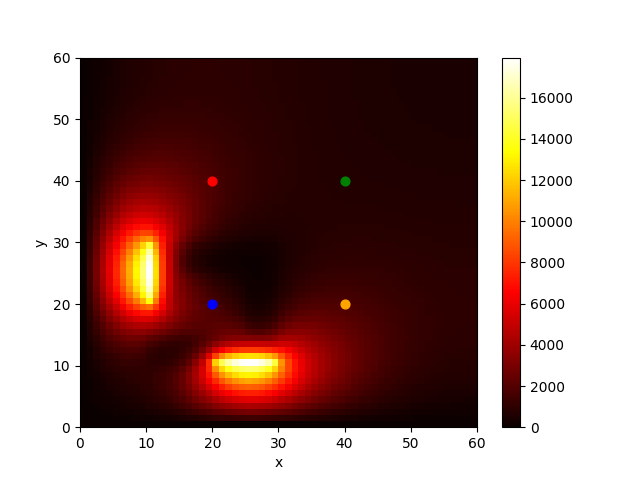

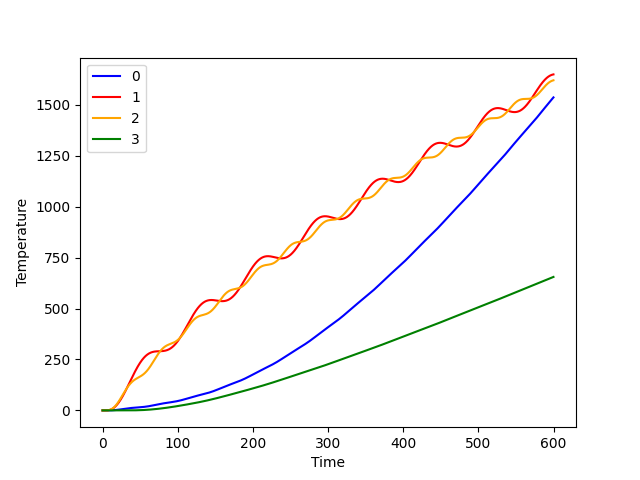

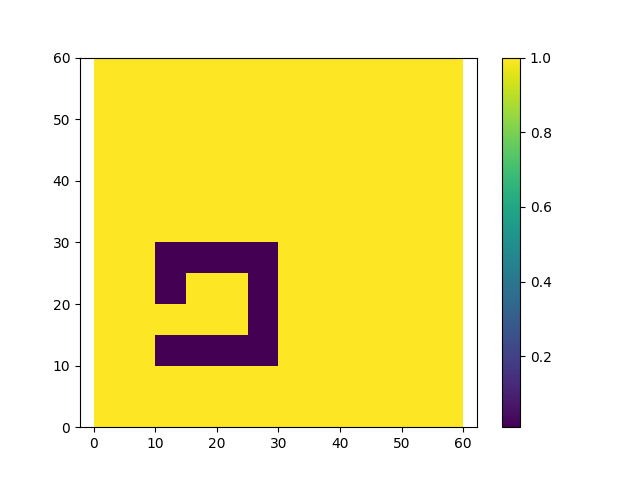

0: [600.]
1: [600.  75.]
2: [600.          42.85714286]
3: [600.]

N = 120:


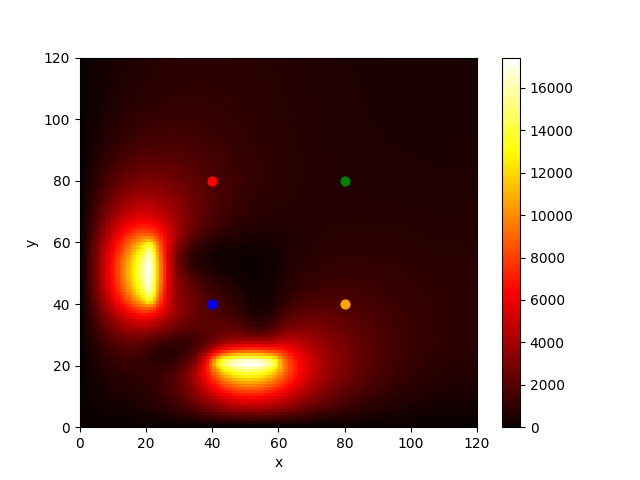

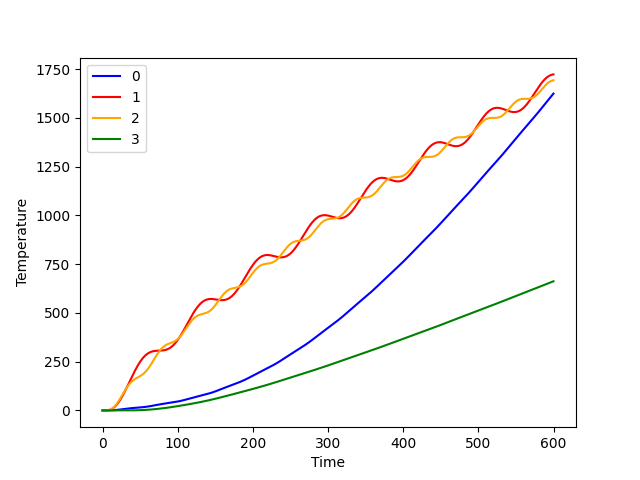

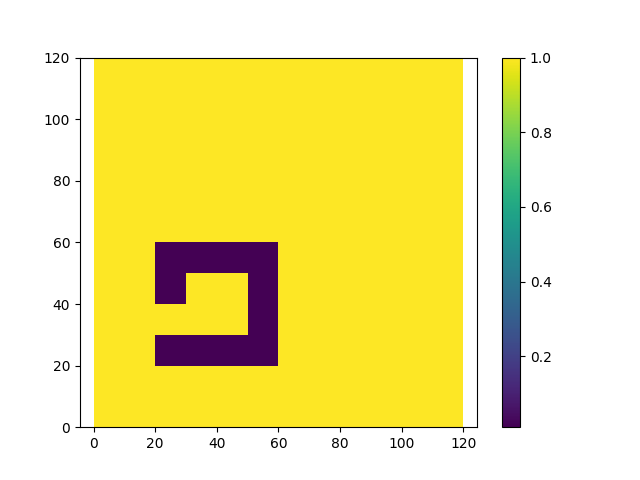

0: [600.]
1: [600.  75.]
2: [600.          42.85714286]
3: [600.]

N = 240:


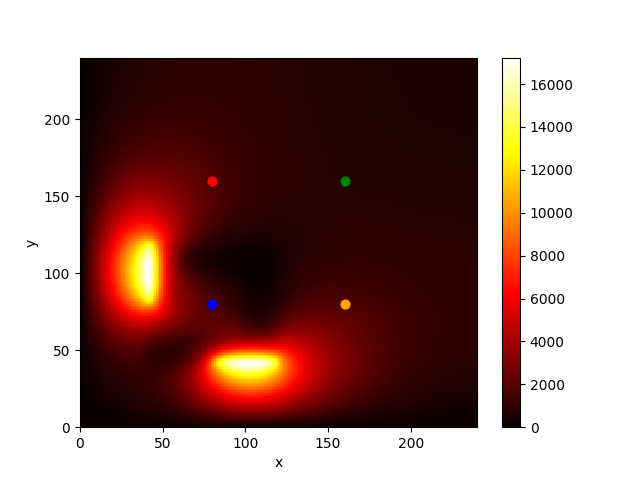

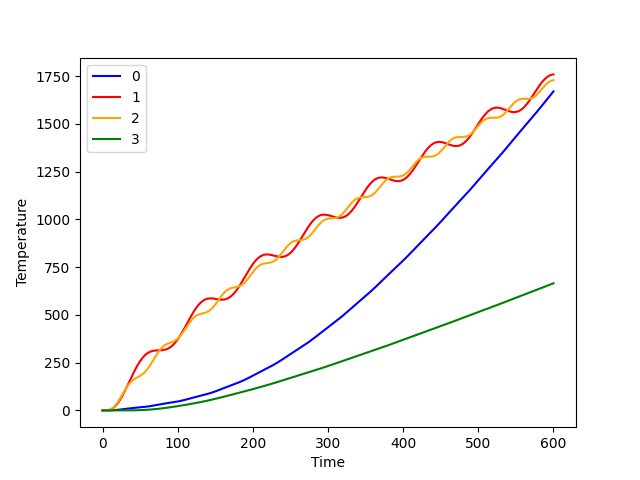

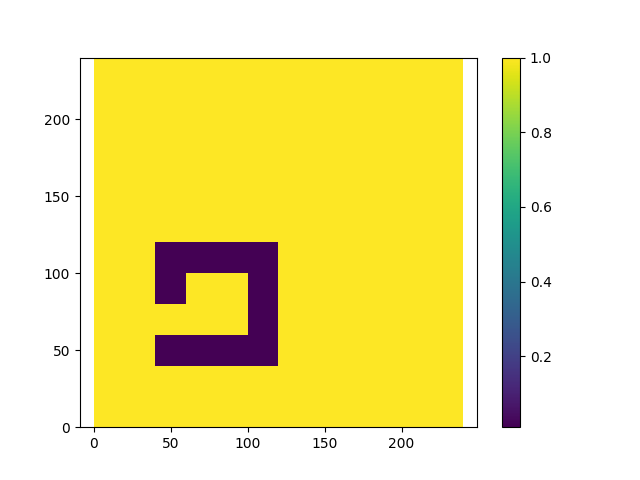

0: [600.]
1: [600.  75.]
2: [600.          42.85714286]
3: [600.]

N = 480:


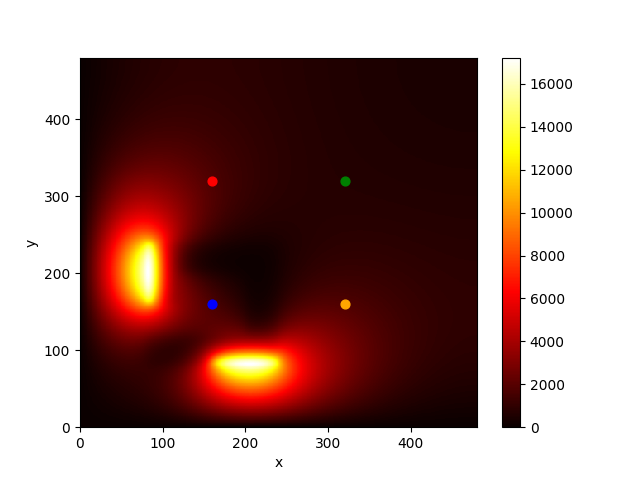

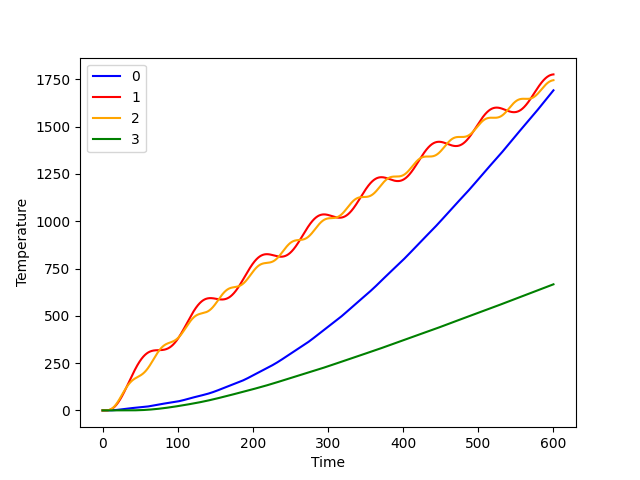

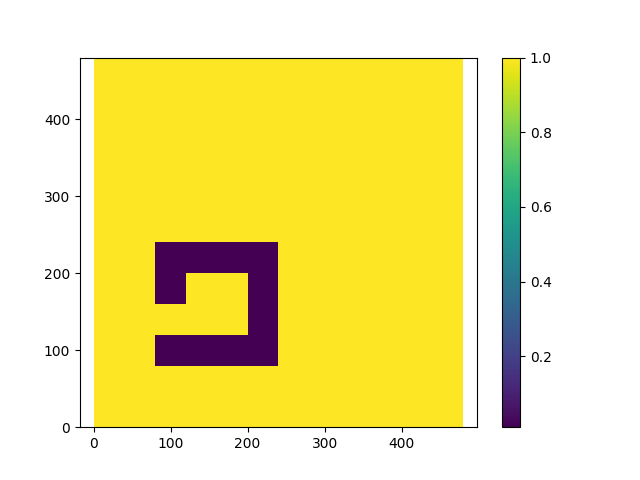

0: [600.]
1: [600.  75.]
2: [600.          42.85714286]
3: [600.]

N = 960:


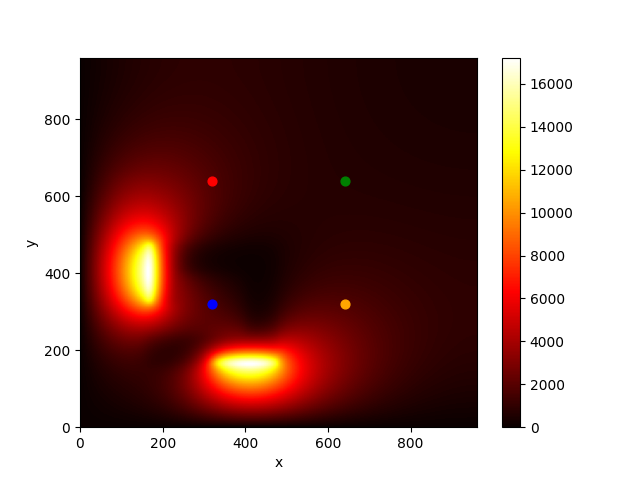

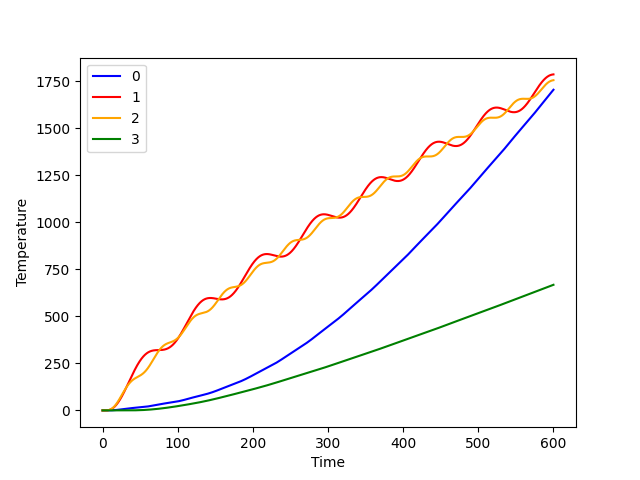

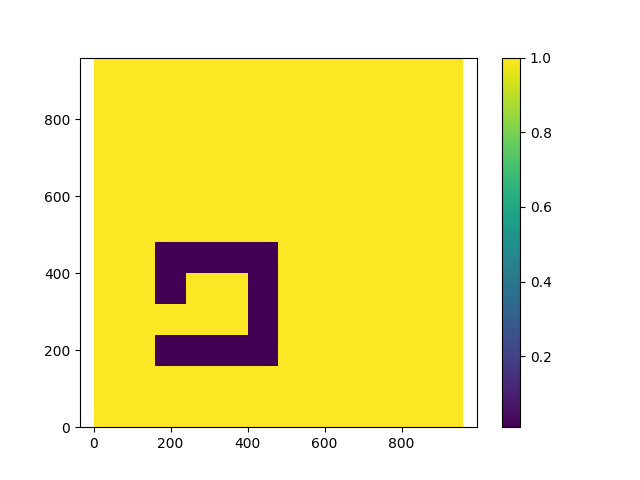

0: [600.]
1: [600.  75.]
2: [600.          42.85714286]
3: [600.]



In [54]:
 for N in N_list:
    with open(f'file_{N}.npy', 'rb') as file:
        L = 60
        dx = L / N
        D_blue = 1.0
        tmax = 600  # максимальное время моделирования (в сек.)
        C = 0.25  # число Курранта
        dt = C * dx ** 2 / D_blue  # время одного шага моделирования

        T = np.load(file)
        D = np.load(file)
        point_values = np.load(file)
        multiplier = int(N / L)  # коэффициент на сколько реальная длина
        points = [
            [20 * multiplier, 20 * multiplier],
            [20 * multiplier, 40 * multiplier],
            [40 * multiplier, 20 * multiplier],
            [40 * multiplier, 40 * multiplier]
        ]  # координаты точек проб

        # заголовок
        print(f'N = {N}:')

        # T
        plt.pcolormesh(T, cmap='hot')
        colors = ['blue', 'red', 'orange', 'green']
        # plt.axis('equal')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.colorbar()
        for i in range(len(points)):
            point = points[i]
            color = colors[i]
            plt.scatter(*point, label=i, color=color, s=40)
        filename = f'T_for_{N}.png'
        plt.savefig(filename)
        plt.close()
        display(Image(filename=filename))

        # график точек
        x_axis = np.arange(0, tmax, dt)
        colors = ['blue', 'red', 'orange', 'green']
        for i in range(len(point_values)):
            point_value = point_values[i]
            color = colors[i]
            plt.plot(x_axis, point_values[i], label=i, color=color)
        plt.xlabel('Time')
        plt.ylabel('Temperature')
        # plt.axis('equal')
        plt.legend()
        filename = f'point_values_for_{N}.png'
        plt.savefig(filename)
        plt.close()
        display(Image(filename=filename))

        # D
        plt.pcolormesh(D)
        plt.colorbar()
        plt.axis('equal')
        filename = f'D_for_{N}.png'
        plt.savefig(filename)
        plt.close()
        display(Image(filename=filename))

        # периоды
        for i in range(len(point_values)):
            point_value = point_values[i]
            p = periods(point_value, dt)
            print(f'{i}: {p}')
        print()